In [ ]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
# Print the device
print(f"Using device: {torch.get_default_device()}")

Using device: cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import string
import unicodedata

allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [ ]:
print(f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


In [ ]:
# Want to convert names to list of tensors
# Will use one-hot encoded vectors to represent single letters
# Each word will be converted to Tensor, where each line represents
# a one-hot encoded vector for a single letter in that given word

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

In [ ]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], device='cuda:0')
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
# Next we need to combine our data into a PyTorch Dataset so we can train, test, and validate
# our models. Each Dataset needs to implement three functions:
# __init__, __len__, __getitem__

from io import open
import glob
import os
import time
from torch.utils.data import Dataset, DataLoader

class NamesDataset(Dataset):
  def __init__(self, data_dir):
    self.data_dir = data_dir
    self.load_time = time.localtime
    labels_set = set()

    self.data = []
    self.data_tensors = []
    self.labels = []
    self.labels_tensors = []

    # read all the .txt files in the specified directory
    text_files = glob.glob(os.path.join(data_dir, '*.txt'))
    for filename in text_files:
      label = os.path.splitext(os.path.basename(filename))[0]
      labels_set.add(label)
      lines = open(filename, encoding='utf-8').read().strip().split('\n')
      for name in lines:
        self.data.append(name)
        self.data_tensors.append(lineToTensor(name))
        self.labels.append(label)

    # Cache the tensor representation of the labels
    self.labels_uniq = list(labels_set)
    for idx in range(len(self.labels)):
      temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
      self.labels_tensors.append(temp_tensor)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data_item = self.data[idx]
    data_label = self.labels[idx]
    data_tensor = self.data_tensors[idx]
    label_tensor = self.labels_tensors[idx]

    return label_tensor, data_tensor, data_label, data_item

In [ ]:
alldata = NamesDataset('/content/drive/MyDrive/data/names')
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([12], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
# can easily split the dataset into train/test splits with datasets
# torch.Generator is not what I though, it is used to control the randomness of ops in PyTorch, not
# act as a generator that can yield results

train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15],
                                                    generator=torch.Generator(device=device).manual_seed(2024))
print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [ ]:
# Next we creat the RNN Network
# We will use the nn.RNN implementation rather than the nn.Linear layers here
# this leads to significant improvement in performance
# https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(CharRNN, self).__init__()

    self.rnn = nn.RNN(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, line_tensor):
    output, hidden = self.rnn(line_tensor)
    output = self.h2o(hidden[0])
    output = self.softmax(output)
    return output

In [ ]:
# next we create an RNN with 57 input nodes, 128 hidden nodes, and 18 outputs

n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
n_letters

57

In [ ]:
# After that we can pass our Tensor to the RNN to obtain a predicted output, we use a helper function
# to derive a text label for the class

# goal of label_from_output is to identify the label with highest predicted value and return
# both the label and its index
def label_from_output(output, output_labels):
  top_n, top_i = output.topk(1)
  label_i = top_i[0].item()
  return output_labels[label_i], label_i

In [ ]:
input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.8022, -3.0365, -2.7991, -3.0052, -2.8170, -2.8690, -2.8956, -2.9771,
         -2.8235, -2.8480, -2.7490, -2.9403, -2.9118, -3.0072, -2.8381, -2.9046,
         -2.8010, -3.0765]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Greek', 10)


In [ ]:
input = lineToTensor('Morrow')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9114, -3.0329, -2.8602, -3.0187, -2.8399, -2.7881, -2.8591, -2.9863,
         -2.7873, -2.8032, -2.7562, -2.9900, -2.9073, -3.0054, -2.8409, -2.8988,
         -2.7972, -3.0173]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Greek', 10)


In [29]:
# Training

import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [30]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.7952609767815223
10 (37%): 	 average batch loss = 0.6460084642165654
15 (56%): 	 average batch loss = 0.5419521691009377
20 (74%): 	 average batch loss = 0.4665013206779026
25 (93%): 	 average batch loss = 0.41459755040597474
training took 407.46607661247253s


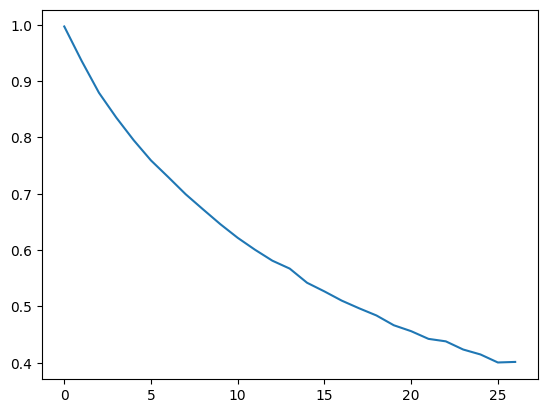

In [31]:
# plotting the loss shows the network learning
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [32]:
# evaluate matrix to see performance
def evaluate(rnn, testing_data, classes):
  confusion = torch.zeros(len(classes), len(classes))

  rnn.eval() # set to eval mode
  with torch.no_grad():
    for i in range(len(testing_data)):
      (label_tensor, text_tensor, label, text) = testing_data[i]
      output = rnn(text_tensor)
      guess, guess_i = label_from_output(output, classes)
      label_i = classes.index(label)
      confusion[label_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(len(classes)):
    denom = confusion[i].sum()
    if denom > 0:
      confusion[i] = confusion[i] / denom

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
  ax.set_yticks(np.arange(len(classes)), labels=classes)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

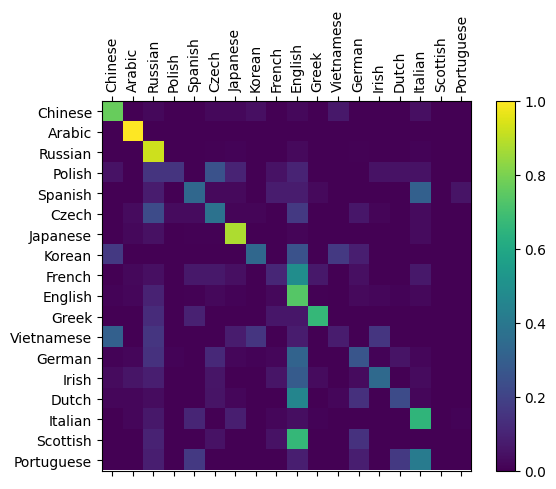

In [33]:
evaluate(rnn, test_set, classes=alldata.labels_uniq)

In [36]:
input = lineToTensor('Morrow')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-6.1293, -5.0532, -1.9523, -3.4764, -4.6085, -3.0114, -6.0163, -8.0410,
         -3.2994, -0.3684, -7.9392, -8.4120, -5.7686, -6.9875, -8.3199, -7.0128,
         -3.9156, -6.1291]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('English', 9)


In [37]:
input = lineToTensor('Jawoisz')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-12.4552, -12.6405,  -0.0610,  -7.7801,  -7.4429,  -5.3217,  -8.0120,
         -12.3114,  -5.4628,  -3.1205,  -7.1941, -11.1540,  -5.7526,  -9.1208,
          -7.9267, -10.0605, -10.9584,  -8.9536]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
('Russian', 2)
